# Frame Differences

This notebook demonstrates that the images with higher speeds differ more than the images with lower speeds.

## Setup
- Download and unpack training data
- Create DonkeyCar project and load configuration

In [5]:
%load_ext autoreload
%autoreload 2
import os
# do we have the correct env loaded?
assert 'donkey' == os.environ['CONDA_DEFAULT_ENV'], os.environ['CONDA_DEFAULT_ENV']

AssertionError: donkey2

In [ ]:
![ ! -d "data/" ] && \
mkdir data && \
curl -L "https://www.dropbox.com/s/eltelvjt12a4ny1/data.zip?dl=1" --output data/data.zip && \
unzip data/data.zip -d data

In [ ]:
![ ! -d "mycar/" ] && \
donkey createcar --path mycar && \
cp config/myconfig.py mycar/

In [1]:
import sys
sys.path.append('donkeycar')
sys.path.append('src')

In [2]:
import numpy as np
import donkeycar as dk
cfg = dk.load_config(config_path='mycar/config.py')
cfg.SEQUENCE_LENGTH = 2

________             ______                   _________              
___  __ \_______________  /___________  __    __  ____/_____ ________
__  / / /  __ \_  __ \_  //_/  _ \_  / / /    _  /    _  __ `/_  ___/
_  /_/ // /_/ /  / / /  ,<  /  __/  /_/ /     / /___  / /_/ /_  /    
/_____/ \____//_/ /_//_/|_| \___/_\__, /      \____/  \__,_/ /_/     
                                 /____/                              

using donkey v4.3.5 ...
loading config file: mycar/config.py
loading personal config over-rides from myconfig.py


### Load tubs

In [54]:
from dataloader import load_records
from collections import OrderedDict

tubs = [
    '1-1-CC-80',
    '2-1-CW-80',
    '4-1-CC-80',
    '1-3-CC-85',
    '2-3-CW-85',
    '3-3-CW-85',
    '4-3-CC-85',
    '1-2-CC-90',
    '2-2-CW-90',
    '3-2-CW-90',
    '4-2-CC-90',
]

tub_records = OrderedDict()

for tub_name in tubs:
    tub_records[tub_name] = load_records(tub_name, cfg, 'data/')


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/1-1-CC-80']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-1-CC-80/catalog_4.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-1-CW-80/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/2-1-CW-80']
INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/4-1-CC-80']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/4-1-CC-80/catalog_5.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/1-3-CC-85']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-3-CC-85/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/2-3-CW-85']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-3-CW-85/catalog_6.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/3-3-CW-85']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/3-3-CW-85/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/4-3-CC-85']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/4-3-CC-85/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/1-2-CC-90']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-2-CC-90/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/2-2-CW-90']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-2-CW-90/catalog_2.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/3-2-CW-90/catalog_6.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/3-2-CW-90']
INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/4-2-CC-90']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/4-2-CC-90/catalog_7.catalog


### On average, do two consecutive images/frames differ more for bigger speeds?

In [22]:

# implement the image diff algo and test it
# plot images diffs
# plot the gt angles and find the range of the number of frames of interest for each speed
# take the images from the ranges found in previous step and plot and focus on their diffs


In [55]:
from skimage.metrics import mean_squared_error
# TODO: TEST my mse with sklearn function, what is the difference with my mse function in the losses.mse?

def mse(image1, image2):
    return np.array((image1 - image2)**2).mean()

def rmse(image1, image2):
    return np.sqrt(mse(image1, image2))

In [56]:
from donkeycar.pipeline.augmentations import ImageAugmentation
from skimage.metrics import normalized_root_mse, mean_squared_error
import pandas as pd

transformation = ImageAugmentation(cfg, 'TRANSFORMATIONS')

for_df = []
for tub_name, records in tub_records.items():
    speed = tub_name[-2:]
    direction = tub_name[-5:-3]
    for (first_tubrecord, second_tubrecord) in records:
        first_image = first_tubrecord.image()
        first_image = transformation.run(first_image)

        second_image = second_tubrecord.image()
        second_image = transformation.run(second_image)

        my_mse = mse(second_image, first_image)
        mse_ = mean_squared_error(second_image, first_image)
        rmse_ = rmse(second_image, first_image)
        nrmse = normalized_root_mse(second_image, first_image)

        tubrecord_index = first_tubrecord.underlying['_index']
        for_df.append([tubrecord_index, tub_name, speed, direction, mse_, rmse_, nrmse, my_mse])

df = pd.DataFrame(for_df, columns=['tubrecord_index', 'tub_name','speed', 'direction', 'MSE', 'RMSE', 'NRMSE', 'MY_MSE'])
df

,tubrecord_index,tub_name,speed,direction,MSE,RMSE,NRMSE,MY_MSE
0,0,1-1-CC-80,80,CC,3.152743,1.775597,0.012099,3.152743
1,1,1-1-CC-80,80,CC,2.589271,1.609121,0.010970,2.589271
2,2,1-1-CC-80,80,CC,0.000000,0.000000,0.000000,0.000000
3,3,1-1-CC-80,80,CC,3.029688,1.730356,0.011865,2.994132
4,4,1-1-CC-80,80,CC,2.906458,1.702225,0.011620,2.897569
...,...,...,...,...,...,...,...,...
47903,7692,4-2-CC-90,90,CC,30.279132,4.705932,0.043598,22.145799
47904,7693,4-2-CC-90,90,CC,21.293229,4.118779,0.036130,16.964340
47905,7694,4-2-CC-90,90,CC,14.637813,3.474036,0.029824,12.068924
47906,7695,4-2-CC-90,90,CC,17.722431,3.563735,0.032889,12.700208


In [57]:
df.groupby('speed').mean()

,tubrecord_index,MSE,RMSE,NRMSE,MY_MSE
speed,,,,,
80,2184.362273,34.211312,3.941741,0.040517,16.359613
85,2450.436305,32.838469,3.910527,0.039529,16.132770
90,3080.192541,53.920445,4.433220,0.050247,20.832125


In [58]:
df.to_csv('image_diffs.csv.gz', index=False)

df.describe()

,tubrecord_index,MSE,RMSE,NRMSE,MY_MSE
count,47908.000000,47908.000000,47908.000000,47908.000000,47908.000000
mean,2606.466352,40.666782,4.103902,0.043582,17.857705
std,1714.906190,38.523298,1.007828,0.018187,9.531725
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1189.000000,17.122344,3.470039,0.030572,12.041172
50%,2421.000000,28.537708,3.908225,0.039635,15.274219
75%,3795.000000,49.988290,4.543403,0.052683,20.642509
max,7696.000000,783.788299,10.715094,0.196218,114.813229


In [59]:
import pandas as pd

df = pd.read_csv('image_diffs.csv.gz')

df.groupby('speed').MSE.mean(), df.groupby('speed').RMSE.mean(), df.groupby('speed').NRMSE.mean()

(speed
 80    34.211312
 85    32.838469
 90    53.920445
 Name: MSE, dtype: float64,
 speed
 80    3.941741
 85    3.910527
 90    4.433220
 Name: RMSE, dtype: float64,
 speed
 80    0.040517
 85    0.039529
 90    0.050247
 Name: NRMSE, dtype: float64)

In [61]:
df.describe()


,tubrecord_index,speed,MSE,RMSE,NRMSE,MY_MSE
count,47908.000000,47908.000000,47908.000000,47908.000000,47908.000000,47908.000000
mean,2606.466352,85.507118,40.666782,4.103902,0.043582,17.857705
std,1714.906190,3.866374,38.523298,1.007828,0.018187,9.531725
min,0.000000,80.000000,0.000000,0.000000,0.000000,0.000000
25%,1189.000000,80.000000,17.122344,3.470039,0.030572,12.041172
50%,2421.000000,85.000000,28.537708,3.908225,0.039635,15.274219
75%,3795.000000,90.000000,49.988290,4.543403,0.052683,20.642509
max,7696.000000,90.000000,783.788299,10.715094,0.196218,114.813229


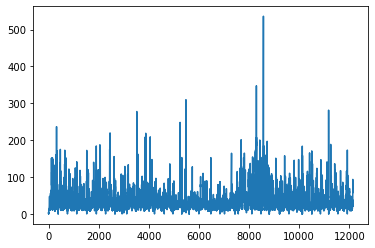

In [62]:
from matplotlib import pyplot as plt
plt.plot(df[df.speed == 80].MSE)


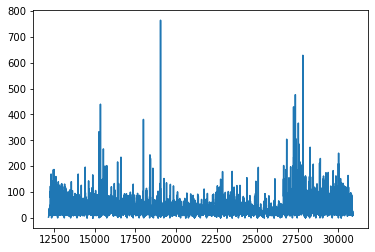

In [63]:
plt.plot(df[df.speed == 85].MSE)


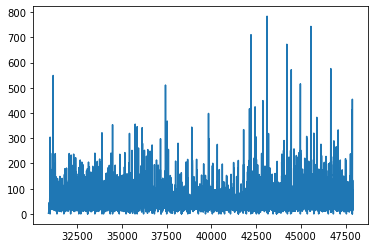

In [64]:
plt.plot(df[df.speed == 90].MSE)


In [65]:
df.sort_values(by=['MSE'], inplace=True, ascending=False)
df

,tubrecord_index,tub_name,speed,direction,MSE,RMSE,NRMSE,MY_MSE
43113,1767,4-2-CC-90,90,CC,783.788299,5.906067,0.190637,34.881632
19046,2733,2-3-CW-85,85,CW,764.180729,8.178743,0.196218,66.891840
45562,4887,4-2-CC-90,90,CC,743.453368,5.801535,0.193152,33.657812
42216,418,4-2-CC-90,90,CC,710.594792,5.836220,0.182979,34.061458
44217,3379,4-2-CC-90,90,CC,672.588403,6.273185,0.168595,39.352847
...,...,...,...,...,...,...,...,...
44973,4298,4-2-CC-90,90,CC,0.000000,0.000000,0.000000,0.000000
4962,1963,2-1-CW-80,80,CW,0.000000,0.000000,0.000000,0.000000
16979,565,2-3-CW-85,85,CW,0.000000,0.000000,0.000000,0.000000
36216,1002,2-2-CW-90,90,CW,0.000000,0.000000,0.000000,0.000000


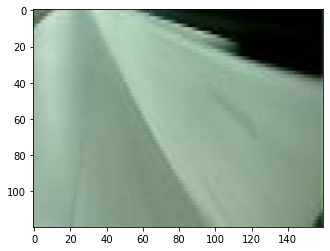

In [85]:
def show_frame(tub_records, tub_name, tubrecord_index):
    records = tub_records[tub_name]
    for (first_tubrecord, second_tubrecord) in records:
        first_image = first_tubrecord.image()
        first_image = transformation.run(first_image)

        if first_tubrecord.underlying['_index'] == tubrecord_index:
            break
    plt.imshow(first_image)


show_frame(tub_records, '4-2-CC-90', 1767)


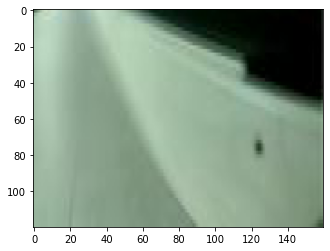

In [86]:
show_frame(tub_records, '4-2-CC-90', 1768)

In [87]:
df[df.MSE < 90].groupby('speed').MSE.mean()

speed
80    29.626740
85    28.705517
90    36.769353
Name: MSE, dtype: float64

In [104]:
df.sort_values(by=['tub_name', 'tubrecord_index'], inplace=True, ascending=True)

In [108]:
slower_speed_tub = '1-3-CC-85'
slower_speed_start_index = 1674
slower_speed_end_index = 1701

slower_speed_clip_df = df[(df.tub_name == slower_speed_tub) & (df.tubrecord_index >= slower_speed_start_index) & (df.tubrecord_index <= slower_speed_end_index)]

slower_speed_clip_df.mean().MSE

15.44193452380952

In [109]:
slower_speed_clip_df

,tubrecord_index,tub_name,speed,direction,MSE,RMSE,NRMSE,MY_MSE
13814,1674,1-3-CC-85,85,CC,11.888438,3.097597,0.024310,9.595104
13815,1675,1-3-CC-85,85,CC,14.476354,3.297932,0.026844,10.876354
13816,1676,1-3-CC-85,85,CC,16.951701,3.377134,0.029065,11.405035
13817,1677,1-3-CC-85,85,CC,15.109931,3.140937,0.027455,9.865486
13818,1678,1-3-CC-85,85,CC,16.310694,3.126877,0.028489,9.777361
13819,1679,1-3-CC-85,85,CC,16.399062,3.259031,0.028517,10.621285
13820,1680,1-3-CC-85,85,CC,13.517708,3.085078,0.025859,9.517708
13821,1681,1-3-CC-85,85,CC,11.481944,3.090802,0.023816,9.553056
13822,1682,1-3-CC-85,85,CC,14.277153,3.417835,0.026618,11.681597
13823,1683,1-3-CC-85,85,CC,11.792153,3.257289,0.024134,10.609931


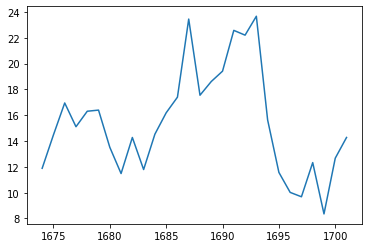

In [110]:
plt.plot(slower_speed_clip_df.tubrecord_index, slower_speed_clip_df.MSE)

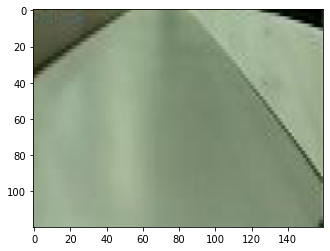

In [111]:
show_frame(tub_records, slower_speed_tub, slower_speed_start_index)

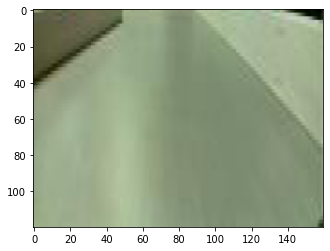

In [112]:
show_frame(tub_records, slower_speed_tub, slower_speed_end_index)

In [119]:
faster_speed_tub = '4-2-CC-90'
faster_speed_start_index = 6975
faster_speed_end_index = 6986

faster_speed_clip_df = df[(df.tub_name == faster_speed_tub) & (df.tubrecord_index >= faster_speed_start_index) & (df.tubrecord_index <= faster_speed_end_index)]

faster_speed_clip_df.mean().MSE

27.785992476851856

In [120]:
faster_speed_clip_df

,tubrecord_index,tub_name,speed,direction,MSE,RMSE,NRMSE,MY_MSE
47186,6975,4-2-CC-90,90,CC,14.001111,3.409953,0.025786,11.627778
47187,6976,4-2-CC-90,90,CC,21.635347,3.984388,0.032088,15.875347
47188,6977,4-2-CC-90,90,CC,18.837535,3.645664,0.029928,13.290868
47189,6978,4-2-CC-90,90,CC,42.670972,5.658020,0.046455,32.013194
47190,6979,4-2-CC-90,90,CC,26.551458,3.627107,0.036449,13.155903
47191,6980,4-2-CC-90,90,CC,31.064340,3.765030,0.039140,14.175451
47192,6981,4-2-CC-90,90,CC,34.932674,3.598674,0.041379,12.950451
47193,6982,4-2-CC-90,90,CC,41.376736,3.260379,0.045036,10.630069
47194,6983,4-2-CC-90,90,CC,16.163924,3.068755,0.028066,9.417257
47195,6984,4-2-CC-90,90,CC,48.043125,6.516885,0.050404,42.469792


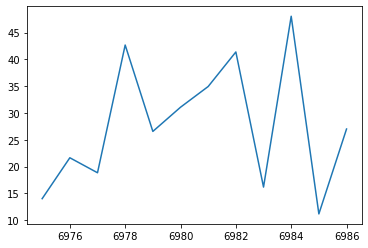

In [121]:
plt.plot(faster_speed_clip_df.tubrecord_index, faster_speed_clip_df.MSE)

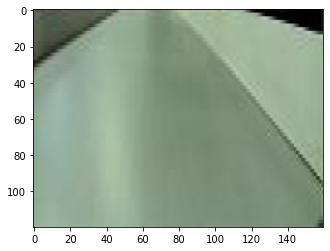

In [122]:
show_frame(tub_records, faster_speed_tub, faster_speed_start_index)

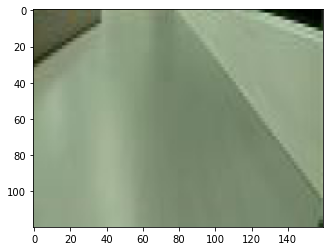

In [123]:
show_frame(tub_records, faster_speed_tub, faster_speed_end_index)


### Conclusion
Images are more different for faster speeds


### Show that when sequence len is < 1 then images are loaded into records properly by donkeycar code

In [124]:
cfg.SEQUENCE_LENGTH = 3
data = load_records('1-2-CC-90', cfg, 'data/')

print([r.underlying['_index'] for r in data[0]])
print([r.underlying['_index'] for r in data[1]])

INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/1-2-CC-90']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-2-CC-90/catalog_4.catalog
[0, 1, 2]
[1, 2, 3]


In [125]:
indices = [r.underlying['_index'] for r in data[1753]]
print(f'the indices of record 1753 are {indices}')
indices = [r.underlying['_index'] for r in data[1754]]
print(f'the indices of record 1754 are {indices}')


the indices of record 1753 are [1753, 1754, 1755]
the indices of record 1754 are [1856, 1857, 1858]


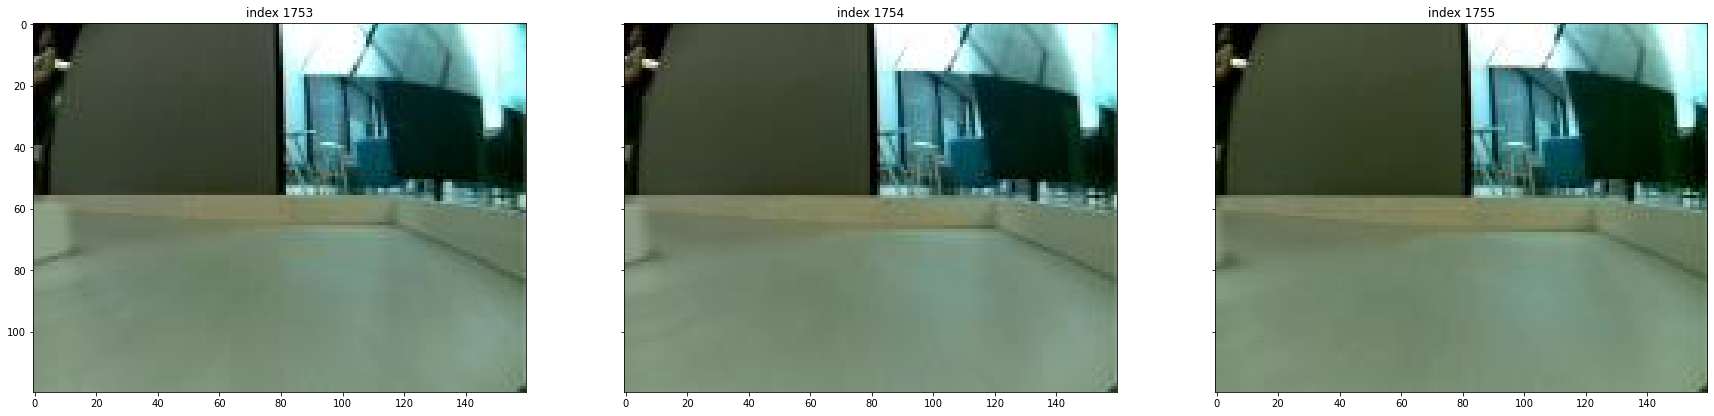

In [126]:
from matplotlib import pyplot as plt

def show_images_of_record(tubrecord):
    assert len(tubrecord) > 1
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 15), sharex='all', sharey='all')
    for r, ax in zip(tubrecord, axs.flat):
        ax.imshow(r.image(as_nparray=False))
        ax.set(title=f"index {r.underlying['_index']}")
    plt.show()

show_images_of_record(data[1753])

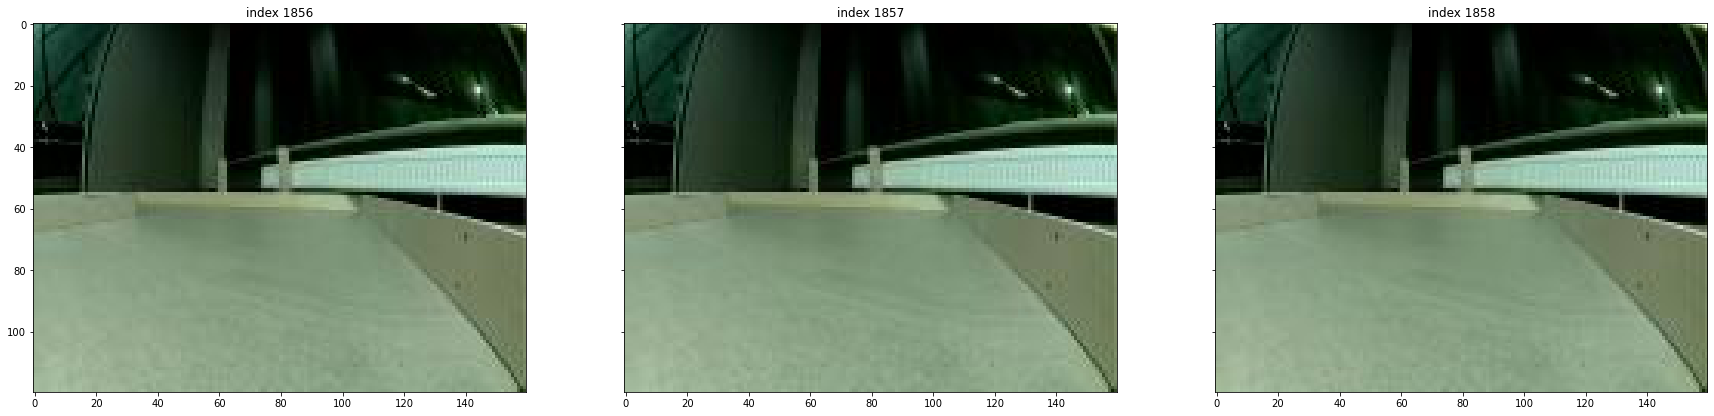

In [127]:
show_images_of_record(data[1754])